## This notebook creates intensity-matrix heatmaps

In [17]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [18]:
def filter_neutral_losses(df, filter_on=True, neutral_losses_to_keep=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    '''
    if filter_on:
        df = df[df.neutral_loss.isin(neutral_losses_to_keep)]
    return df

def calculate_detected_intensities(df):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    '''
    intensities_for_twostate_spots = (df.pred_twostate == 1) * df.spot_intensity_bgr_corrected
    df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
    intensities_for_threestate_spots = (df.pred_threestate == 2) * df.spot_intensity_bgr_corrected
    df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
    return df

def filter_polarity(df, polarity):
    '''
    Filter out entries based on polarity pol ['pos', 'neg']
    '''
    return df[df['Polarity'] == polarity]

def filter_class(df, clas, clas_column):
    '''
    Filter out entries based on coarse class name
    '''
    return df[df[clas_column] == clas]

def make_heatmap_input(df, intensity_col_name = 'val_threestate'):
    '''
    Pivot table so that it can be used for heatmap plotting
    '''
    return df.pivot_table(index=['name_short'],
                          columns=['sample_name'],
                          values=intensity_col_name,
                          aggfunc=lambda x: np.log10(sum(x)+1),
                          fill_value=0,
                          sort=False)

def prep_colour_bar(plot_df, class_df, class_column):
    '''
    Make a colour bar representing classes of compounds in heatmap
    '''
    class_to_color = dict(zip( class_df[class_column].unique(), 
                               sns.hls_palette( class_df[class_column].nunique(), h=.5 )))
    name_to_class =  dict(zip( class_df.name_short,
                               class_df[class_column] ))
    
    row_colors = plot_df.index.map(name_to_class).map(class_to_color)
    return class_to_color, row_colors

- Inputs

In [19]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/heatmaps"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "datasets.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
# p_pathways = p_data / "pathways_v2.csv"

- Load files

In [20]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

# TODO: remove thermometer ions?

chem_class = pd.read_csv(p_chem_class, index_col='internal_id')
# pathways = pd.read_csv(p_pathways, index_col='internal_id')

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Clone ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code']] # 'Participant lab', 'Technology'
datasets_info['sample_name'] = datasets_info['Matrix short']
# datasets_info['sample_name'] = datasets_info['Matrix short'] + '_' + datasets_info['Slide code']

# Merge with predictions and classification
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Clone ID', how='left')

### Part 1: One heatmap with all chemical classes

In [21]:
def prep_all_class_data(data, polarity, nl_filter_on=None, neutral_losses_to_keep=None, intensity_col_name=None):
    '''
    Prepare data and make one heatmap for all classes
    '''
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = calculate_detected_intensities(data)
    data = filter_polarity(data, polarity)
    data = make_heatmap_input(data, intensity_col_name)
    
    # sort columns alphabetically
    column_order = data.columns.sort_values()
    data.reindex(column_order, axis=1)
    return data

def plot_all_class_heatmap(plot_data, cmap, row_colors, lut, row_cluster, col_cluster, title):
    '''Plot one heatmap for with classes'''
    g = sns.clustermap(plot_data, metric="euclidean", 
                       yticklabels=False, 
                       row_colors=row_colors,
                       row_cluster=row_cluster,
                       col_cluster=col_cluster,
                       cmap=cmap,
                       vmax=5.5) # set max value of the colour bar

    # Beautify the plot
    ax = g.ax_heatmap # define axes
    ax.set(xlabel=None, ylabel=None) # hide axes labels
    g.ax_row_dendrogram.set_visible(False) # hiderow dendrogram

        # Set title and give it space above the plot
    g.fig.subplots_adjust(top=0.9, right=0.95)
    g.fig.suptitle(title)
    
        # Adjust colour bar size and location            
    g.ax_cbar.set_position((0.96, 0.075, 0.03, 0.65)) #x, y, w, l

        # Construct legend
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Chemical class',
               bbox_to_anchor=(0.17, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')        
    return g

- Assign one chemical class to each compound
- Sort data by class so that it looks nice in unclustered heatmap

In [22]:
main_chem_class = chem_class[['name_short', 'main_coarse_class']].drop_duplicates()
data = df.merge(main_chem_class, on='name_short', how='left')
data.sort_values(by = ['main_coarse_class', 'name_short'], inplace=True)

- Plot just one heatmap with filters of interest

In [23]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s') #, as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

<ipython-input-18-f340a801df33>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-18-f340a801df33>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)


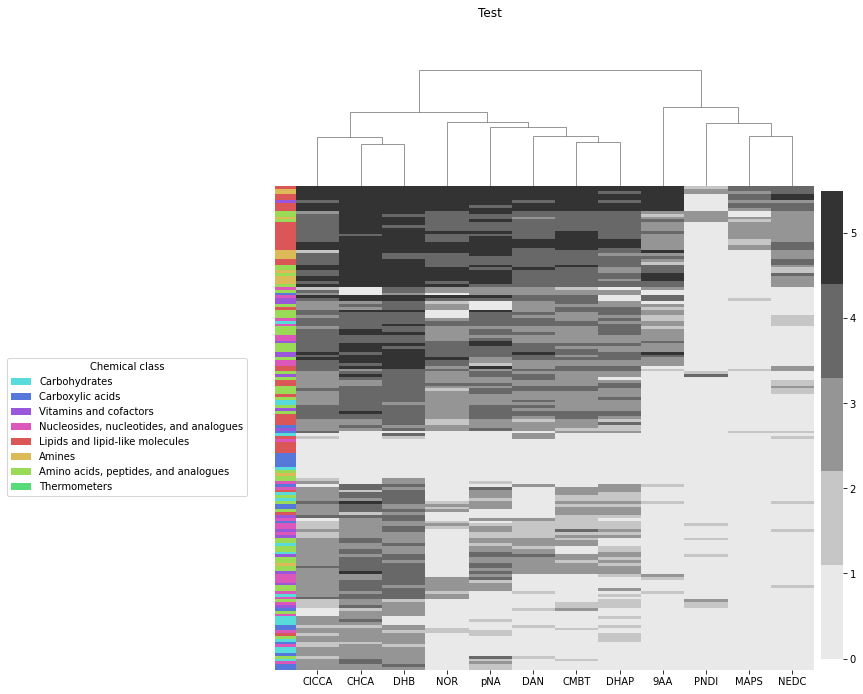

In [25]:
# Prepare data to plot
plot_data = prep_all_class_data(data,
                                polarity='pos', 
                                nl_filter_on=True, 
                                neutral_losses_to_keep=[''], 
                                intensity_col_name='val_threestate')

# plot_data.to_csv(p_out / f"data_for_seriation.csv")

# Prepare a colour bar
lut, row_colors = prep_colour_bar(plot_data, 
                                  main_chem_class, 
                                  'main_coarse_class')

# Make the plot
g = plot_all_class_heatmap(plot_data,
                           cmap,
                           row_colors, 
                           lut, 
                           row_cluster=True, 
                           col_cluster=True,
                           title = f"Test")

# Save the plot
# g.savefig(p_out / f"log10 intensities.png") 

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With 50% (val_twostate) or 80% (val_threestate) ion detection confidence

In [27]:
for nl_filter_on in [True, False]:
    
    nl_label = 'with n.l.'
    if nl_filter_on: 
        nl_label = 'no n.l.'       
    
    for polarity in ['pos', 'neg']:
        
        for catboost in ['val_twostate', 'val_threestate']:

            # Prepare data to plot
            plot_data = prep_all_class_data(data,
                                 polarity=polarity, 
                                 nl_filter_on=nl_filter_on, 
                                 neutral_losses_to_keep=[''], 
                                 intensity_col_name=catboost)
            
            # Save data for seriation in R
            plot_data.to_csv(p_out / f"data_for_seriation_{polarity}_{catboost}_{nl_label}.csv")

            # Prepare a colour bar
            lut, row_colors = prep_colour_bar(plot_data,
                                                     main_chem_class, 
                                                     'main_coarse_class')
            # Make the plot
            title = f"log10 intensities {nl_label} {polarity} {catboost}"
            g = plot_all_class_heatmap(plot_data, 
                                       cmap,
                                       row_colors, 
                                       lut, 
                                       row_cluster=False, 
                                       col_cluster=False, # Change this to enable column clustering
                                       title=title)

            # Save the plot
            g.savefig(p_out / f"{title}.png")
            plt.close()  

<ipython-input-18-f340a801df33>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-18-f340a801df33>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)


### Part 2: Seriation in R

- Could be done on csvs saved in part 1
- Describe how you do it if you do it

### Part 3: Class-specific plots

In [28]:
def prep_one_class_data(data, polarity, clas, nl_filter_on=None, neutral_losses_to_keep=None, intensity_col_name=None):
    '''
    Prepare data and make one heatmap for all classes
    '''
    data = filter_neutral_losses(data, nl_filter_on, neutral_losses_to_keep)
    data = calculate_detected_intensities(data)
    data = filter_class(data, clas, 'coarse_class')
    data = filter_polarity(data, polarity)
    data = make_heatmap_input(data, intensity_col_name)
    
    # sort columns alphabetically
    column_order = data.columns.sort_values()
    data.reindex(column_order, axis=1)
    return data

def plot_one_class_heatmap(plot_data, cmap, row_colors, lut, row_cluster, col_cluster, title):
    '''Plot one heatmap for with classes'''
    g = sns.clustermap(plot_data, metric="euclidean", 
                       yticklabels=True, 
                       row_colors=row_colors,
                       row_cluster=row_cluster,
                       col_cluster=col_cluster,
                       cmap=cmap,
                       vmax=5.5) # set max value of the colour bar

    # Beautify the plot
    ax = g.ax_heatmap # define axes
    ax.set(xlabel=None, ylabel=None) # hide axes labels
    g.ax_row_dendrogram.set_visible(False) # hiderow dendrogram

        # Set title and give it space above the plot
    g.fig.subplots_adjust(top=0.9, right=0.95)
    g.fig.suptitle(title)
    
        # Adjust colour bar size and location            
    g.ax_cbar.set_position((0.14, 0.075, 0.03, 0.65)) #x, y, w, l

        # Construct legend
    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Chemical class',
               bbox_to_anchor=(0.1, 0.5), bbox_transform=plt.gcf().transFigure, loc='upper right')        
    return g

- Map molecules and their chemical classes. Here one molecule can belong to several classes

In [29]:
data = df.merge(chem_class[['name_short', 'coarse_class', 'fine_class']], on='name_short', how='left')
data.sort_values(by = ['fine_class', 'name_short'], inplace=True)

- Plot just one heatmap with filters of interest

In [30]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s')#, as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

<ipython-input-18-f340a801df33>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-18-f340a801df33>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)


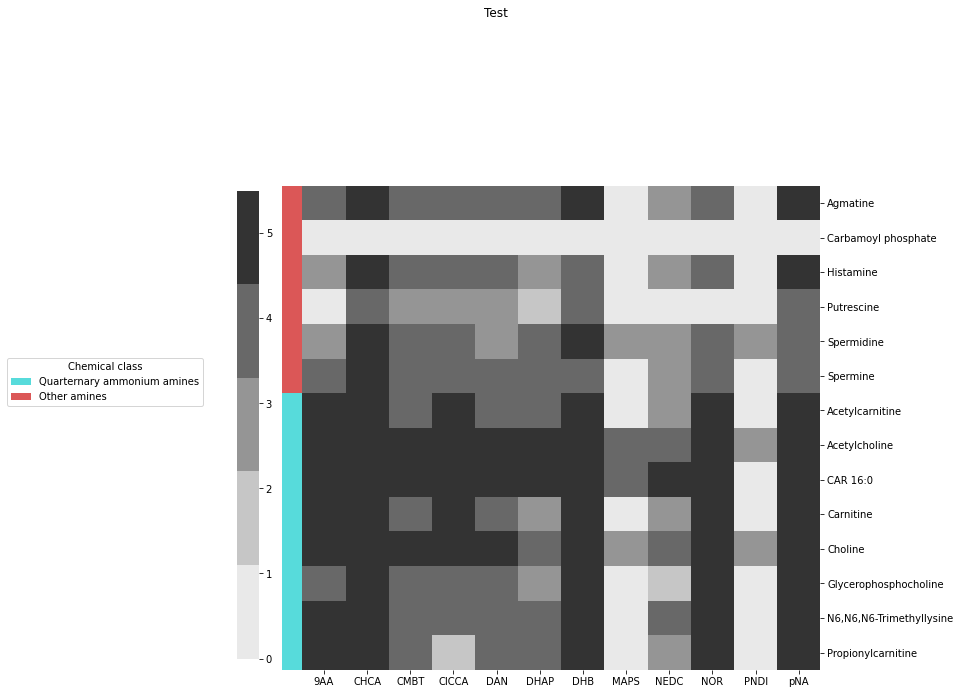

In [31]:
# Prepare data to plot
plot_data = prep_one_class_data(data,
                     polarity='pos',
                     clas='Amines',
                     nl_filter_on=True, 
                     neutral_losses_to_keep=[''], 
                     intensity_col_name='val_threestate')

# # plot_data.to_csv(p_out / f"data_for_seriation.csv")

# Prepare a colour bar
lut, row_colors = prep_colour_bar(plot_data, 
                                         chem_class[chem_class['coarse_class'] == 'Amines'], 
                                         'fine_class')

# Make the plot
g = plot_one_class_heatmap(plot_data, 
                           cmap,
                           row_colors, 
                           lut, 
                           row_cluster=False, 
                           col_cluster=False,
                           title = f"Test")

# # # Save the plot
# # g.savefig(p_out / f"log10 intensities.png") 

- Batch-save separate plots for every coarse class with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With 50% (val_twostate) or 80% (val_threestate) ion detection confidence

In [34]:
for clas in data.coarse_class.unique():
    
    for nl_filter_on in [True, False]:

        nl_label = 'with n.l.'
        if nl_filter_on: 
            nl_label = 'no n.l.'       

        for polarity in ['pos', 'neg']:

            for catboost in ['val_twostate', 'val_threestate']:

                # Prepare data to plot
                plot_data = prep_one_class_data(data,
                                                polarity=polarity,
                                                clas=clas,
                                                nl_filter_on=nl_filter_on, 
                                                neutral_losses_to_keep=[''], 
                                                intensity_col_name=catboost)

                # Prepare a colour bar
                lut, row_colors = prep_colour_bar(plot_data, 
                                                  chem_class[chem_class['coarse_class'] == clas], 
                                                  'fine_class')
                # Make the plot
                title = f"log10 intensities {clas} {nl_label} {polarity} {catboost}"
                g = plot_one_class_heatmap(plot_data,
                                           cmap,
                                           row_colors, 
                                           lut, 
                                           row_cluster=True, 
                                           col_cluster=True,
                                           title=title)

                # Save the plot
                g.savefig(p_out / f"{title}.png")
                plt.close()  

<ipython-input-18-f340a801df33>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_twostate'] = np.clip(intensities_for_twostate_spots, 0, None)
<ipython-input-18-f340a801df33>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['val_threestate'] = np.clip(intensities_for_threestate_spots, 0, None)
